$$- \nabla \cdot (a(x, \omega_1) \cdot \nabla u(x)) = f(x) \hspace{0.2cm} \text{on} \hspace{0.2cm} D(\omega_2)$$

In [89]:
import matplotlib.pyplot as plt
import fenics as fe
import mshr
import numpy as np
from scipy.linalg import eigh
from scipy.interpolate import griddata

In [90]:
# Constants
CENTER = fe.Point(0, 0)
RADIUS = 1
DOMAIN = mshr.Circle(CENTER, RADIUS)
DIRICHLET_BC = fe.Constant(0)

In [91]:
def v_cov1_1(x, y):
    return 5.0/100.0 * np.exp(-4.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))
def v_cov1_2(x, y):
    return 1.0/100.0 * np.exp(-0.1 * ((2*x[0] - y[0])**2 + (2*x[1] - y[1])**2))
def v_cov2_1(x, y):
    return 1.0/100.0 * np.exp(-0.1 * ((x[0] - 2*y[0])**2 + (x[1] - 2*y[1])**2))
def v_cov2_2(x, y):
    return 5.0/100.0 * np.exp(-1.0 * ((x[0] - y[0])**2 + (x[1] - y[1])**2))

SIGMA = 1.0
l = 0.1
def z_cov(x, y):
    # Exponential Covariance Function
    return SIGMA**2 * np.exp(-np.sqrt((x[0] - y[0])**2 + (x[1] + x[1])**2) / l)

In [92]:
# Helpers eigenpair calculation
class BasisFunction():
    def __init__(self, basis_function: fe.Function, coordinates: np.array):
        self.function = basis_function
        self.coordinates = coordinates

def get_C_entry(mc_samples_for_c_entries, f, basis_function_i: BasisFunction, basis_function_j: BasisFunction, max_edge_length: float):
    def integrand(x, y):
        return f(x, y) * basis_function_i.function(x) * basis_function_j.function(y)
    # generate MC samples
    angles_x = np.random.uniform(0, 2 * np.pi, mc_samples_for_c_entries)
    radii_x = np.sqrt(np.random.uniform(0, max_edge_length, mc_samples_for_c_entries))
    x1_samples = basis_function_i.coordinates[0] + radii_x * np.cos(angles_x)
    x2_samples = basis_function_i.coordinates[1] + radii_x * np.sin(angles_x)
    angles_y = np.random.uniform(0, 2 * np.pi, mc_samples_for_c_entries)
    radii_y = np.sqrt(np.random.uniform(0, max_edge_length, mc_samples_for_c_entries))
    y1_samples = basis_function_j.coordinates[0] + radii_y * np.cos(angles_y)
    y2_samples = basis_function_j.coordinates[1] + radii_y * np.sin(angles_y)
    C_entry = 0
    for (x1, x2) in zip(x1_samples, x2_samples):
        for (y1, y2) in zip(y1_samples, y2_samples):
            C_entry += integrand([x1, x2], [y1, y2])
    return C_entry / (mc_samples_for_c_entries**2) * np.pi * max_edge_length**2

def v_calculate_random_field_eigenpairs(mesh_resolution_c_entries, mc_samples_for_c_entries):  
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_c_entries)
    max_edge_length = mesh.hmax()
    V = fe.FunctionSpace(mesh, "CG", 1)
    V_Vector = fe.VectorFunctionSpace(mesh, "CG", 1)
    N = V.dim()
    dof_coordinates = V.tabulate_dof_coordinates().reshape((-1, 2))

    basis_functions = []
    basis_functions_grads = []
    for i in range(N):
        basis_function = fe.Function(V)
        basis_function.vector()[i] = 1.0
        basis_function.set_allow_extrapolation(True)
        basis_functions.append(BasisFunction(basis_function, dof_coordinates[i]))
        grad = fe.project(fe.grad(basis_function), V_Vector)
        grad.set_allow_extrapolation(True)
        basis_functions_grads.append(BasisFunction(grad, dof_coordinates[i]))

    C = np.zeros((2 * N, 2 * N))
    for i, basis_function_i in enumerate(basis_functions):
        for j, basis_function_j in enumerate(basis_functions):
            if j <= i:
                # Here we use that each block is symmetric because of the symmetry of the covariance functions
                C[i, j] = C[j, i] = get_C_entry(mc_samples_for_c_entries, v_cov1_1, basis_function_i, basis_function_j, max_edge_length)
                C[i, N + j] = C[j, N + i] = get_C_entry(mc_samples_for_c_entries, v_cov1_2, basis_function_i, basis_function_j, max_edge_length)
                C[N + i, j] = C[N + j, i] = get_C_entry(mc_samples_for_c_entries, v_cov2_1, basis_function_i, basis_function_j, max_edge_length)
                C[N + i, N + j] = C[N + j, N + i] = get_C_entry(mc_samples_for_c_entries, v_cov2_2, basis_function_i, basis_function_j, max_edge_length)
    
    M = np.zeros((2 * N, 2 * N))
    for i, basis_function_i in enumerate(basis_functions):
        for j, basis_function_j in enumerate(basis_functions):
            if i >= j:
                integrand = basis_function_j.function * basis_function_i.function * fe.dx
                M[i, j] = M[j, i] = M[N + i, N + j] = M[N + j, N + i] = fe.assemble(integrand)
        
    J = N # Number of eigenvectors -> J = N is maximum
    eigenvalues, eigenvectors = eigh(C, M, subset_by_index=[0, J-1])
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    for index, sorted_eigenvalue in enumerate(sorted_eigenvalues):
        if sorted_eigenvalue < 0:
            sorted_eigenvalues[index] = 0
    return sorted_eigenvalues, sorted_eigenvectors, basis_functions, basis_functions_grads, N, J

def z_calculate_random_field_eigenpairs(mesh_resolution_c_entries, mc_samples_for_c_entries):  
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_c_entries)
    max_edge_length = get_max_edge_length(mesh)
    V = fe.FunctionSpace(mesh, "CG", 1)
    N = V.dim()
    dof_coordinates = V.tabulate_dof_coordinates().reshape((-1, 2))

    basis_functions = []
    for i in range(N):
        basis_function = fe.Function(V)
        basis_function.vector()[i] = 1.0
        basis_function.set_allow_extrapolation(True)
        basis_functions.append(BasisFunction(basis_function, dof_coordinates[i]))

    C = np.zeros((N, N))
    for i, basis_function_i in enumerate(basis_functions):
        for j, basis_function_j in enumerate(basis_functions):
            if j <= i:
                # Here we use that each block is symmetric because of the symmetry of the covariance functions
                C[i, j] = C[j, i] = get_C_entry(mc_samples_for_c_entries, z_cov, basis_function_i, basis_function_j, max_edge_length)
    
    M = np.zeros((N, N))
    for i, basis_function_i in enumerate(basis_functions):
        for j, basis_function_j in enumerate(basis_functions):
            if i >= j:
                integrand = basis_function_j.function * basis_function_i.function * fe.dx
                M[i, j] = M[j, i] = fe.assemble(integrand)
        
    J = N # Number of eigenvectors -> J = N is maximum
    eigenvalues, eigenvectors = eigh(C, M, subset_by_index=[0, J-1])
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    for index, sorted_eigenvalue in enumerate(sorted_eigenvalues):
        if sorted_eigenvalue < 0:
            sorted_eigenvalues[index] = 0
    return sorted_eigenvalues, sorted_eigenvectors, basis_functions, N, J

In [ ]:
###### Section 1 ######
###### Calculation of the eigenpairs for the two random fields ###### 

# Inputs
# 3, 100 takes approximately 5 minutes
v_mesh_resolution_c_entries = 3
v_mc_samples_for_c_entries = 100

# Calculate the eigenpairs
v_eigenvalues, v_eigenvectors, v_basis_functions, v_basis_functions_grads, v_N, v_J = v_calculate_random_field_eigenpairs(v_mesh_resolution_c_entries, v_mc_samples_for_c_entries)

In [93]:
# Inputs
# 4, 100 takes approximately 3 minutes
# 5, 100 takes approximately 5 minutes
z_mesh_resolution_c_entries = 4
z_mc_samples_for_c_entries = 100

z_eigenvalues, z_eigenvectors, z_basis_functions, z_N, z_J = z_calculate_random_field_eigenpairs(z_mesh_resolution_c_entries, z_mc_samples_for_c_entries)

  Building point search tree to accelerate distance queries.
  Computed bounding box tree with 121 nodes for 61 points.


In [75]:
print(f"Eigenvalues of z: {z_eigenvalues}")
print(f"Eigenvectors of z: {z_eigenvectors}")

Eigenvalues of z: [2.43502484e+01 1.41992278e+01 3.02115440e+00 1.79616077e+00
 1.39693330e+00 1.25639466e+00 1.03727735e+00 7.38169800e-01
 6.76641702e-01 4.56578176e-01 3.77992441e-01 2.16638043e-01
 1.90383822e-01 1.66060995e-01 1.51660958e-01 1.34919904e-01
 1.18168207e-01 9.27634534e-02 7.88054909e-02 5.44719240e-02
 5.04037715e-02 4.30217466e-02 4.15472322e-02 3.11770781e-02
 2.79659937e-02 2.17529362e-02 1.00386609e-02 6.16353690e-03
 5.34712308e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Eigenvectors of z: [[-1.50713231  4.09647568  1.38422932 ... -6.88329866  0.21461873
   0.30420637]
 [-1.75812624  4.90910961  

In [104]:
# Helpers sampling
def v_random_field(x, eigenvalues, eigenvectors, xi, basis_functions, N, J):
    return x[0] + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions[k].function(x) for k in range(N)]) * xi[j] for j in range(J)]), \
           x[1] + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions[k].function(x) for k in range(N)]) * xi[j] for j in range(J)])

def v_jacobian(x, eigenvalues, eigenvectors, xi, basis_functions_grads, N, J):
    jacobian_output = np.zeros((2, 2))
    jacobian_output[0, 0] = 1 + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[0, 1] = sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[1, 0] = sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[k, j] * basis_functions_grads[k].function(x)[1] for k in range(N)]) * xi[j] for j in range(J)])
    jacobian_output[1, 1] = 1 + sum([np.sqrt(eigenvalues[j]) * sum([eigenvectors[N + k, j] * basis_functions_grads[k].function(x)[0] for k in range(N)]) * xi[j] for j in range(J)])
    return jacobian_output

def a_hat_random_field(x, v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions, v_N, v_J, \
          z_eigenvalues, z_eigenvectors, z_xi, z_basis_functions, z_N, z_J):
    # log-normal random field with a_hat = exp(z(V(x)))
    # mean of z = 0
    x_hat = v_random_field(x, v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions, v_N, v_J)
    z = sum([np.sqrt(z_eigenvalues[j]) * sum([z_eigenvectors[k, j] * z_basis_functions[k].function(x_hat) for k in range(z_N)]) * z_xi[j] for j in range(z_J)])
    a = np.exp(z)
    print(f"x: {x}, x_hat: {x_hat}, z: {z}, a: {a}")
    return a

class BExpression(fe.UserExpression):
    def __init__(self, v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions, v_basis_functions_grads, v_N, v_J,
                 z_eigenvalues, z_eigenvectors, z_xi, z_basis_functions, z_N, z_J, **kwargs):
        super().__init__(**kwargs)
        self.v_eigenvalues = v_eigenvalues
        self.v_eigenvectors = v_eigenvectors
        self.v_xi = v_xi
        self.v_basis_functions = v_basis_functions
        self.v_basis_functions_grads = v_basis_functions_grads
        self.v_N = v_N
        self.v_J = v_J

        self.z_eigenvalues = z_eigenvalues
        self.z_eigenvectors = z_eigenvectors
        self.z_xi = z_xi
        self.z_basis_functions = z_basis_functions
        self.z_N = z_N
        self.z_J = z_J

    def eval(self, values, x):
        J_x = v_jacobian(x, self.v_eigenvalues, self.v_eigenvectors, self.v_xi, self.v_basis_functions_grads, self.v_N, self.v_J)
        inv_JTJ = np.linalg.inv(J_x.T @ J_x)
        det_J = np.linalg.det(J_x)
        a_hat = a_hat_random_field(x, self.v_eigenvalues, self.v_eigenvectors, self.v_xi, self.v_basis_functions, self.v_N, self.v_J, \
          self.z_eigenvalues, self.z_eigenvectors, self.z_xi, self.z_basis_functions, self.z_N, self.z_J)
        B_x = a_hat * inv_JTJ * det_J
        values[0] = B_x[0, 0]
        values[1] = B_x[0, 1]
        values[2] = B_x[1, 0]
        values[3] = B_x[1, 1]

    def value_shape(self):
        return (2, 2)

class detJExpression(fe.UserExpression):
    def __init__(self, v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions_grads, v_N, v_J, **kwargs):
        super().__init__(**kwargs)
        self.v_eigenvalues = v_eigenvalues
        self.v_eigenvectors = v_eigenvectors
        self.v_xi = v_xi
        self.v_basis_functions_grads = v_basis_functions_grads
        self.v_N = v_N
        self.v_J = v_J
        
    def eval(self, values, x):
        J_x = v_jacobian(x, self.v_eigenvalues, self.v_eigenvectors, self.v_xi, self.v_basis_functions_grads, self.v_N, self.v_J)
        det_J = np.linalg.det(J_x)
        values[0] = det_J

    def value_shape(self):
        return ()
    
def solve_poisson_for_given_sample(mesh_resolution_fem_single, f, v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions,
                                   v_basis_functions_grads, v_N, v_J,
                                   z_eigenvalues, z_eigenvectors, z_xi, z_basis_functions, z_N, z_J):
    mesh = mshr.generate_mesh(DOMAIN, mesh_resolution_fem_single)
    V = fe.FunctionSpace(mesh, "CG", 3) #! degree 3
    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)
    B_expr = BExpression(v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions, v_basis_functions_grads, v_N, v_J,
                 z_eigenvalues, z_eigenvectors, z_xi, z_basis_functions, z_N, z_J, degree=2)
    a = fe.inner(fe.dot(B_expr, fe.grad(u)), fe.grad(v)) * fe.dx
    det_J_expr = detJExpression(v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions_grads, v_N, v_J, degree=2)
    L = f * det_J_expr * v * fe.dx
    bc = fe.DirichletBC(V, DIRICHLET_BC, 'on_boundary')
    u_sol = fe.Function(V)
    fe.solve(a == L, u_sol, bc)
    return u_sol

In [101]:
x = fe.Point(0,0)
v_xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), v_J)
z_xi = np.random.normal(0, 1, z_J)

mesh = mshr.generate_mesh(DOMAIN, 64)
V = fe.FunctionSpace(mesh, 'P', 1)
a_hat_function = fe.Function(V)
for i, x in enumerate(mesh.coordinates()):
    a_hat_value = a_hat_random_field(x, v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions, v_N, v_J, 
                                     z_eigenvalues, z_eigenvectors, z_xi, z_basis_functions, z_N, z_J)
    a_hat_function.vector()[i] = a_hat_value

x: [-0.99987786  0.01562918], x_hat: (-1.4878008725315701, -0.04731956929230794), z: -14.443016267176603, a: 5.339218979644336e-07
x: [-0.99987786 -0.01562918], x_hat: (-1.5282584250163196, -0.05465461830896336), z: -15.240255028195776, a: 2.4056992813299216e-07
x: [-0.99890089 -0.04687226], x_hat: (-1.4859514983408229, -0.05597553893346793), z: -14.363813860262194, a: 5.779295507245315e-07
x: [-0.99694792 -0.07806955], x_hat: (-1.4413704191419523, -0.05659136421853228), z: -13.443951634519063, a: 1.4499932821840171e-06
x: [-0.99402084 -0.10919055], x_hat: (-1.394558746914518, -0.0565014924506316), z: -12.481567134364385, a: 3.795983080704688e-06
x: [-0.99012251 -0.14020487], x_hat: (-1.3455622206318738, -0.0557060114421042), z: -11.477600691064152, a: 1.0359561056811672e-05
x: [-0.98525676 -0.1710822 ], x_hat: (-1.2944287140550585, -0.05420569844535146), z: -10.433033264968897, a: 2.9443621317230506e-05
x: [-0.97942832 -0.20179236], x_hat: (-1.2412081889560684, -0.052002019393396104),

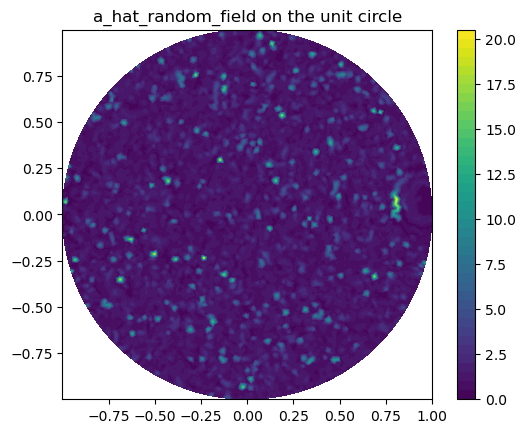

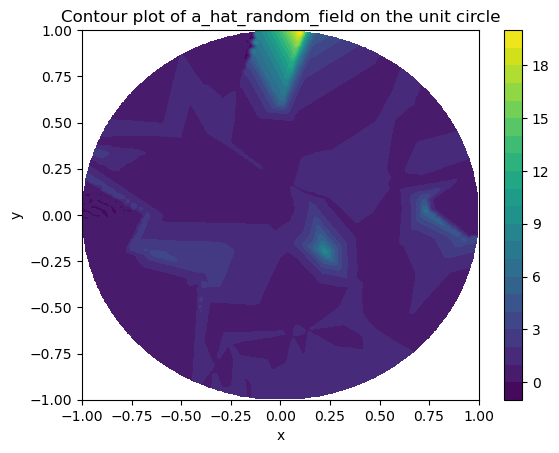

In [102]:
# Plot the function using FEniCS and Matplotlib
plt.figure()
c = fe.plot(a_hat_function)
plt.title('a_hat_random_field on the unit circle')
plt.colorbar(c)
plt.show()


# Create a grid of points for the contour plot
x_coords = mesh.coordinates()[:, 0]
y_coords = mesh.coordinates()[:, 1]
z_values = a_hat_function.vector().get_local()

grid_x, grid_y = np.mgrid[-1:1:500j, -1:1:500j]
grid_z = griddata((x_coords, y_coords), z_values, (grid_x, grid_y), method='cubic')


# Create the contour plot using Matplotlib
plt.figure()
contour = plt.contourf(grid_x, grid_y, grid_z, levels=20, cmap='viridis')
plt.colorbar(contour)
plt.title('Contour plot of a_hat_random_field on the unit circle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

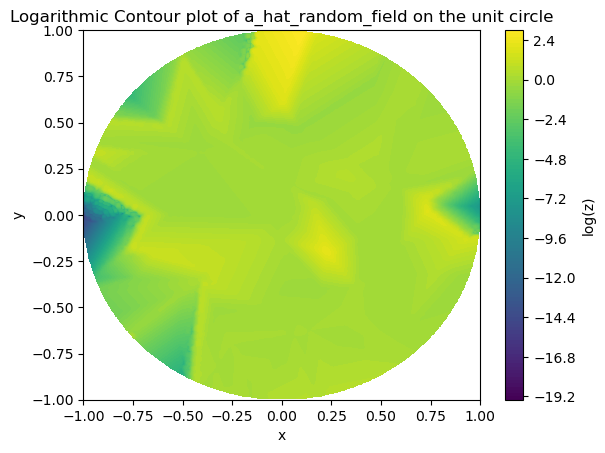

In [103]:
grid_x, grid_y = np.mgrid[-1:1:500j, -1:1:500j]  # Increased resolution
grid_z = griddata((x_coords, y_coords), z_values, (grid_x, grid_y), method='cubic')

# Apply a logarithmic transformation to the z-values
log_grid_z = np.log(np.abs(grid_z) + 1e-10)  # Adding a small value to avoid log(0)

# Create the contour plot using Matplotlib with a logarithmic z-scale
plt.figure()
contour = plt.contourf(grid_x, grid_y, log_grid_z, levels=120, cmap='viridis')
plt.colorbar(contour, label='log(z)')
plt.title('Logarithmic Contour plot of a_hat_random_field on the unit circle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

  Solving linear variational problem.
x: [ 0.21345986 -0.46020462], x_hat: (0.07263027050647528, -0.4191068993014921), z: -0.06757953220366003, a: 0.9346533826167565
x: [-0.08599808 -0.70825793], x_hat: (0.22898913164172785, -0.6911663506858525), z: -0.09209172044665381, a: 0.9120214946898679
x: [ 0.18399958 -0.72942351], x_hat: (0.06651304941004943, -0.688302800300859), z: -0.05015360501969657, a: 0.9510833221075454
x: [ 0.04900075 -0.71884072], x_hat: (0.06569335550279949, -0.6645873225432899), z: -0.026543257870055712, a: 0.973805918154541
x: [ 0.19872972 -0.59481407], x_hat: (0.07276955130686069, -0.5632061257766428), z: 0.04583051101324972, a: 1.0468969584145225
x: [ 0.06373089 -0.58423128], x_hat: (-0.08481529565201845, -0.5002233528531201), z: -0.14487911479071555, a: 0.8651268678323208
x: [ 0.21345986 -0.46020462], x_hat: (0.07263027050647528, -0.4191068993014921), z: -0.06757953220366003, a: 0.9346533826167565
x: [-0.08599808 -0.70825793], x_hat: (0.22898913164172785, -0.69116

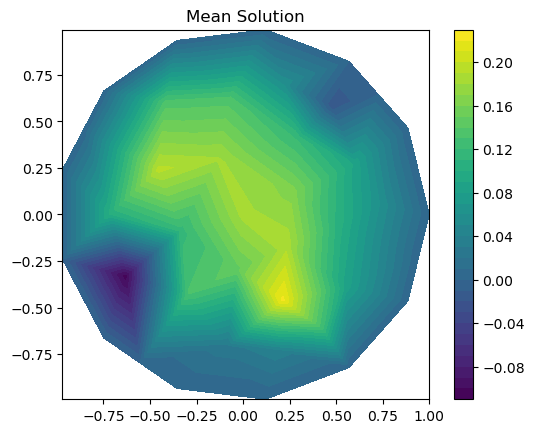

In [105]:
mesh_resolution = 4
f = fe.Constant(1)
mc_sample_size = 5 # 5 samples currently take approximately 7 minutes

u_sols = []
for i in range(mc_sample_size):
    v_xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), v_J)
    a_xi = np.random.uniform(-np.sqrt(3), np.sqrt(3), z_J)
    u_sols.append(solve_poisson_for_given_sample(mesh_resolution, f, v_eigenvalues, v_eigenvectors, v_xi, v_basis_functions,
                                   v_basis_functions_grads, v_N, v_J,
                                   z_eigenvalues, z_eigenvectors, z_xi, z_basis_functions, z_N, z_J))

mesh = mshr.generate_mesh(DOMAIN, mesh_resolution)
V = fe.FunctionSpace(mesh, "CG", 3)
mean_sol = fe.Function(V)
mean_sol.vector()[:] = 0
for u_sol in u_sols:
    mean_sol.vector()[:] += u_sol.vector() / mc_sample_size

c = fe.plot(mean_sol, title='Mean Solution')
plt.colorbar(c)
plt.show()
